# Project: Kernelization, Kernel Tricks

**Put any package imports you need in the below space**

In [1]:
# Required Imports
import random
import matplotlib.pyplot as plt
import sklearn.datasets
import numpy as np
import math
from sklearn.cross_validation import cross_val_score as cvs
import sklearn.metrics as sm
from tabulate import tabulate
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm
random.seed(42)
np.random.seed(42)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,8)

**Exercise 1: Generating the data sets.**

Write a script that generates three data sets in a 2-dimensional space, defined as follows:
1. BAD_kmeans: a data set for which the k-means clustering algorithm will not perform well.
2. BAD_pca: a data set for which the Principal Component Analysis (PCA) dimension reduction method upon projection of the original points onto 1-dimensional space (i.e., the first eigenvector) will not perform well.
3. BAD_svm: a data set for which the linear Support Vector Machine (SVM) supervised classification method using two classes of points (positive and negative)  will not perform well.
4. Plot each data set in a 2-dimensional space.
    
Note: If appropriate, the same data set may be used for multiple parts.

In [2]:
def circular_data(inner, outer, size=100):
    x,y = [], []
    for _ in range(size*size):
        alpha = 2 * math.pi * random.random()
        r = outer * random.random()
        tx = r * math.cos(alpha)
        ty = r * math.sin(alpha)
        if inner <= abs(tx) <= outer or inner <= abs(ty) <= outer:
            x.append([tx])
            y.append([ty])
    return np.array(x[:size]), np.array(y[:size])

def bad_kmeans(lab=False):
    len1, len2 = 50, 100
    x1,y1 = circular_data(0,250,len1)
    x2,y2 = circular_data(650,1000,len2)
    x = np.vstack((x1,x2))
    y = np.vstack((y1,y2))
    labels = [0]*len(x1)+[1]*len(x2)
    if lab:
        return x,y,labels
    return x,y

In [3]:
bad_km_x, bad_km_y = bad_kmeans()
X = np.hstack((bad_km_x,bad_km_y))
# Ref: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
kmeans = KMeans(n_clusters=2).fit(X)
# _ = plt.scatter(x,y, c = kmeans.labels_)

In [4]:
def bad_pca():
    return bad_kmeans()
bad_pca_x, bad_pca_y = bad_pca()
X_pca = np.hstack((bad_pca_x,bad_pca_y))
# Ref: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca2 = PCA(n_components=2).fit(X_pca)
pca1 = PCA(n_components=1).fit(X_pca)
# print(pca2.explained_variance_ratio_)
# print(pca1.explained_variance_ratio_)

In [5]:
def bad_lsvm():
    return bad_kmeans()
# Ref: http://scikit-learn.org/stable/modules/svm.html
bad_lsvm_x, bad_lsvm_y = bad_lsvm()
X_lsvm = np.hstack((bad_lsvm_x,bad_lsvm_y))
X_1 = np.copy(X_lsvm)
np.random.shuffle(X_1)
twothirds = int(len(X_1)*.67)
X_SVM = X_1[twothirds]
Y = np.random.randint(2, size=len(X_1))
clf = svm.SVC(kernel='linear').fit(X_1,Y)
# labels = clf.predict(X_1[100:])
# _ = plt.scatter(X_1[100:,0], X_1[100:,1], c=labels)

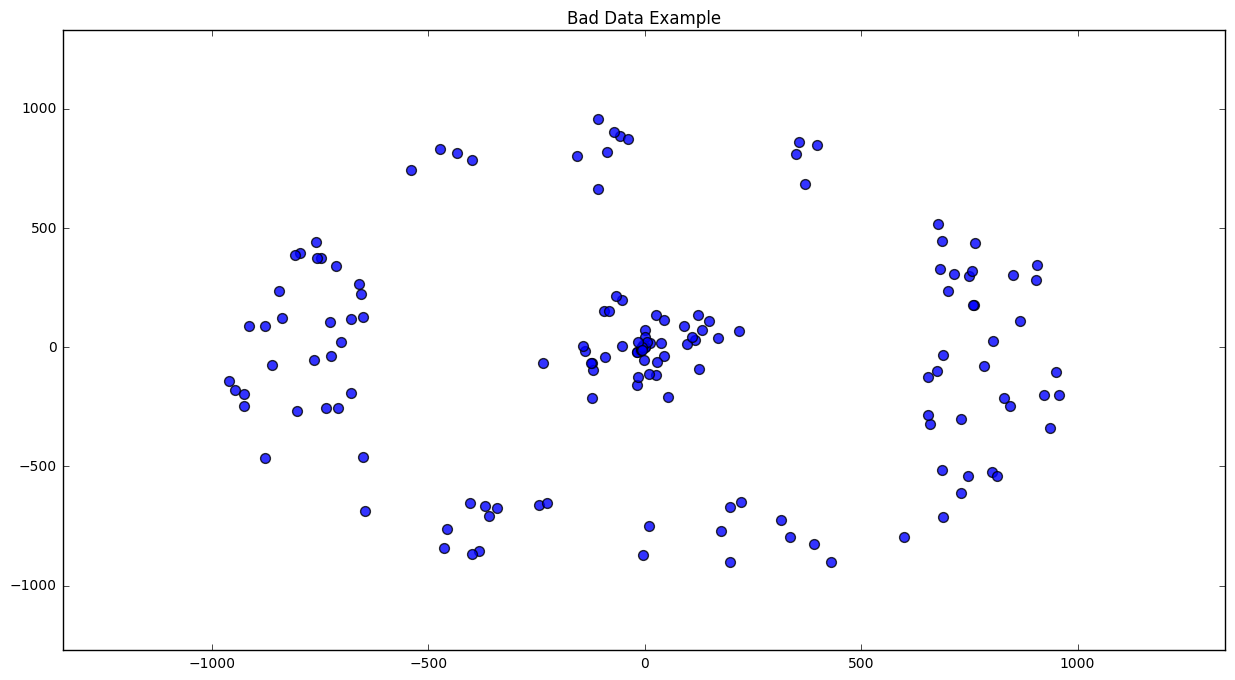

In [6]:
data_x, data_y, labels = bad_kmeans(lab=True)
X_data = np.hstack((data_x, data_y))
_ = plt.scatter(data_x, data_y, alpha=0.8, s=50)
# _ = plt.scatter(data_x, data_y, alpha=0.8, s=50,c=labels)
_ = plt.title("Bad Data Example")
plt.margins(0.2)

-----------------------------------------------------------------------

**Exercise 2: Evaluating the "badness" of the data mining methods.**

Write a script that uses the BAD data sets in Exercise 1, runs the corresponding data mining method, produces the output of the method, and evaluates the performance of the method using (e.g., 10-fold) cross-validation and various performance metrics (e.g., variance, precision, recall, F1 measure). Note that not all metrics can be equally applied to every method. Report the performance metrics used and a summary of the results obtained. Reading the chapter “Performance Metrics for Graph Mining Tasks” by Kanchana Padmanabhan and John Jenkins in the resources for performance metrics is strongly encouraged for performing this exercise. 

In [7]:
def get_metrics(X_data):
    
    twothirds = int(len(X_data)*2/3)
    eigthy = int(len(X_data)*0.8)
    X_train = X_data[:twothirds]
    X_test = X_data[twothirds:]
    labels_test = labels[-len(X_test):]
    
    # Running the models
    model_km, model_pca, model_svm = KMeans(n_clusters=2), PCA(n_components=1), svm.SVC(kernel='linear')
    kmeans1 = model_km.fit(X_data)
    pca1 = model_pca.fit(X_data)
    svm1 = model_svm.fit(X_train, labels[:twothirds])
    
    # Cross Validation Scores
    score_km = cvs(model_km, X_data, labels, cv=10)
    score_pca = cvs(model_pca, X_data, labels, cv=10)
    score_svm = svm1.score(X_test, labels[twothirds:])
    print("Cross Validation Scores")
    print(np.mean(score_km), np.mean(score_pca), np.mean(score_svm))
    
    # Ref: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    confmat_km = sm.confusion_matrix(labels, kmeans1.labels_)
    f1_km = sm.f1_score(labels, kmeans1.labels_)
    precision_km = sm.precision_score(labels, kmeans1.labels_)
    recall_km = sm.recall_score(labels, kmeans1.labels_)

    var_pca = pca1.explained_variance_ratio_

    svm_labels = svm1.predict(X_test)
    confmat_svm = sm.confusion_matrix(labels[-len(svm_labels):], svm_labels)
    f1_svm = sm.f1_score(labels_test, svm_labels)
    precision_svm = sm.precision_score(labels_test, svm_labels)
    recall_svm = sm.recall_score(labels_test, svm_labels)
    
    print("\n")
    performance_metrics = tabulate([["KMeans", f1_km, precision_km, recall_km, '-'], 
                                    ["PCA", '-','-','-',var_pca[0]], 
                                    ["LinearSVM", f1_svm, precision_svm, recall_svm, '-']],
                                  headers = ["Method", "F1 Score", "Precision", "Recall", "Variance"], tablefmt="orgtbl")
    print(performance_metrics)
    print("\n")
    print("Number of support vectors : %r" % svm1.n_support_)

In [8]:
get_metrics(X_data)

Cross Validation Scores
-4712019.26633 -15.2790608304 0.32


| Method    | F1 Score            | Precision          | Recall   | Variance           |
|-----------+---------------------+--------------------+----------+--------------------|
| KMeans    | 0.6351351351351351  | 0.9791666666666666 | 0.47     | -                  |
| PCA       | -                   | -                  | -        | 0.6001882901670579 |
| LinearSVM | 0.48484848484848486 | 1.0                | 0.32     | -                  |


Number of support vectors : array([49, 50])


**Summary of Performance Metrics**

As you can see from the metrics calculated above, KMeans performs very poorly. A low Precision and a high recall score indicate how badly the method performed.

The variance of PCA is about 0.54, so reduction to one-dimension using PCA only retains about 0.54% of original data.

LinearSVM performs better than KMeans. It has a lower recall, and a higher accuracy, as can be inferred from Confusion Matrix.

---------------------------------------------------------------

**Exercise 3: Kernelizing the methods.**

Write a script that uses the kernelized version of each of the data mining methods in Exercise 2.
1. Choose at least two kernels for each method.
2. Use the same performance metrics as in Exercise 2 and compare the performance of the original un-kernelized version of the method versus the performance obtained after applying the kernel trick.
3. Do you observe a difference in performance when you use different kernels?
4. What are the best performance results you obtain by trying different kernels and kernel parameters? Also, make sure to report the number of support vectors for the SVM (a good rule of thumb is to strive for no more than 35%-50% support vectors to avoid model overfitting).

In [9]:
# Kernel 1 - Gaussian
def euc_dist(n1, n2):
    return round(math.sqrt(math.pow(n1[0]-n2[0],2) + math.pow(n1[1]-n2[1],2)),3)
def kernel_gaus(n1, n2, sigma=1):
    return math.exp((-0.5*euc_dist(n1,n2)/sigma))
def kernel_poly(n1, n2, const=0, dim=3):
    return (const + np.dot(n1,n2))**dim

In [10]:
def create_affinity_matrix(data, f):
    size = len(data)
    aff_mat = [[0]*size for i in range(size)]
    for i in range(size):
        for j in range(size):
            if i==j: aff_mat[i][j] = 0
            else: aff_mat[i][j] = f(data[i],data[j])
    return aff_mat

In [11]:
X_data_k1 = create_affinity_matrix(X_data, kernel_gaus)
X_data_k2 = create_affinity_matrix(X_data, kernel_poly)

**KERNEL 1 - Gaussian **

In [12]:
get_metrics(X_data_k1)

Cross Validation Scores
-0.20084666576 438.968114937 1.0


| Method    | F1 Score   | Precision   | Recall   | Variance           |
|-----------+------------+-------------+----------+--------------------|
| KMeans    | 0.0        | 0.0         | 0.0      | -                  |
| PCA       | -          | -           | -        | 0.4491091250707652 |
| LinearSVM | 1.0        | 1.0         | 1.0      | -                  |


Number of support vectors : array([50, 50])


**KERNEL 2 - Polynomial **

In [13]:
get_metrics(X_data_k2)

Cross Validation Scores
-3.82937066547e+37 -6094.57483096 0.08


| Method    | F1 Score            | Precision   | Recall   | Variance           |
|-----------+---------------------+-------------+----------+--------------------|
| KMeans    | 0.5714285714285715  | 1.0         | 0.4      | -                  |
| PCA       | -                   | -           | -        | 0.6153140584066069 |
| LinearSVM | 0.14814814814814814 | 1.0         | 0.08     | -                  |


Number of support vectors : array([ 1, 50])


** Observations about Kernels **

The first kernel (Gaussian distance) improves the performance of Linear SVM. We can see that it gives a perfect precision for SVMs. But other methods perform poorly.

The second kernel (Polynomial kernel) improves the performance of all three methods. K-means gets improved F1-score. PCA variance increases to 55%. And # of Support Vectors is also within resp bounds.

----------------------------------------------------------------

**Exercise 4: Pipelining.**

Dimension reduction is often used as a key data pre-processing step for other data mining methods downstream the end-to-end data analysis. In this exercise, you will use unsupervised kernel PCA as a pre-processing step for clustering. Later in the course, we will use supervised dimension reduction methods as a pre-processing step for supervised classification methods.
1. Generalize your BAD_kmeans data set to very high-dimensional space (d>>2).
2. Show that the k-means clustering algorithm does not perform well on that data.
3. Apply the kernel PCA method to this high dimensional data set and identify the number (m<<d) of principal components (i.e., eigenvectors) that provide a reasonably good low-dimensional approximation of your data (i.e., based on eigenvalue distribution). How much total variability of the data will be preserved upon using this low-dimensional representation?
4. Project your original data onto the top m eigenvectors corresponding to the largest eigenvalues.
5. Run the k-means clustering algorithm on the projected low dimensional data.
6. Compare the performance of the k-means clustering algorithm on the d-dimensional original data vs. the m-dimensional projected data. Has the performance improved?
7. If you run the kernel k-means clustering algorithm on the original data, will you get better or worse performance? Discuss the pros and cons of using kernel k-means on the original data directly versus applying kernel PCA as a pre-processing step and then running the k-means clustering algorithm on the low-dimensional data.

In [14]:
def multd_circ_data(inner, outer, size=100):
    obs = []
    for _ in range(size*size):
        alpha = 2 * math.pi * random.random()
        r = outer * random.random()
        d1 = r * math.cos(alpha)
        d2 = r * math.sin(alpha)
        d3 = r * math.cos(alpha) * math.sin(alpha)
        d4 = r * math.cos(alpha) * math.cos(alpha)
        d5 = r * math.sin(alpha) * math.sin(alpha)
        if inner <= abs(d1) <= outer or inner <= abs(d2) <= outer or inner <= abs(d3) <= outer or inner <= abs(d5) <= outer or inner <= abs(d4) <= outer :
            obs.append([d1,d2,d3,d4,d5])
    return obs[:size]

def bad_kmeans(lab=False):
    len1, len2 = 50, 100
    data1 = multd_circ_data(0,250,len1)
    data2 = multd_circ_data(650,1000,len2)
    labels = [0]*len(data1)+[1]*len(data2)
    if lab:
        return data1, data2,labels
    return data1, data2

In [15]:
d1, d2, multdlables_ = bad_kmeans(True)
X_multd = np.vstack((d1,d2))
mod_kmeans = KMeans()
kmeans = mod_kmeans.fit(X_multd)
print("Cross Validation Score = %r" % np.mean(cvs(mod_kmeans, X_multd, labels, cv=10)))

Cross Validation Score = -1420008.8648247849


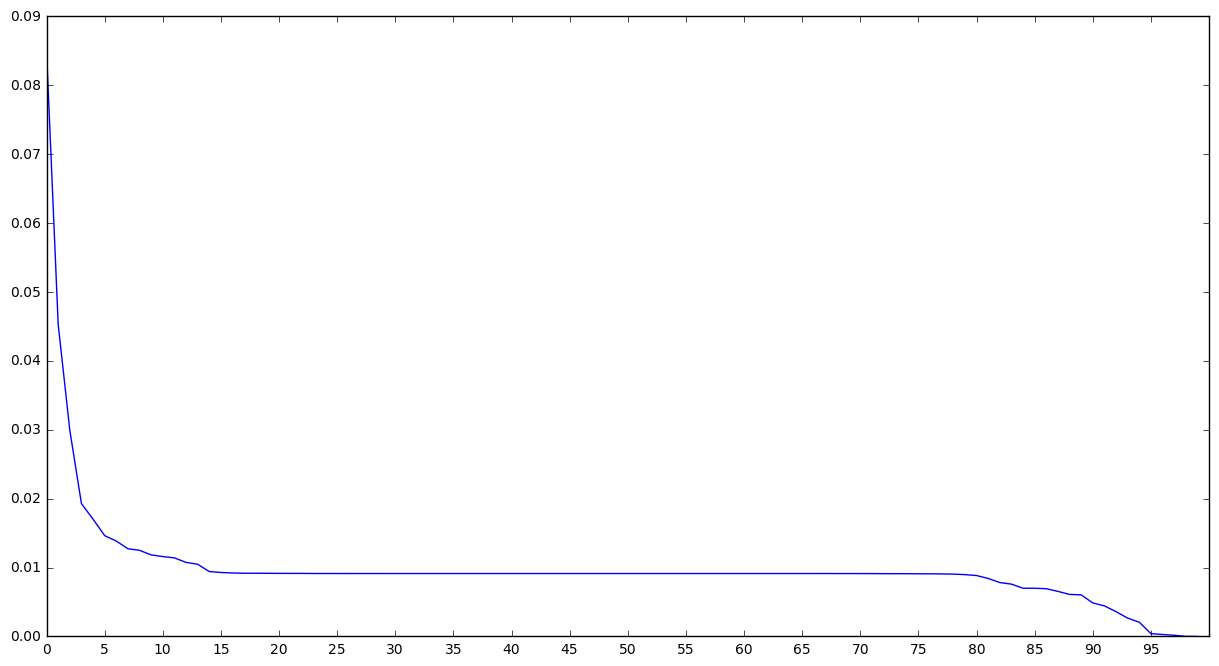

In [16]:
from sklearn.metrics.pairwise import pairwise_kernels
X_multd_temp = np.copy(X_multd)
np.random.shuffle(X_multd_temp)
X_multd_train = X_multd_temp[:twothirds]
X_multd_test = X_multd_temp[twothirds:]

kpca_trainData = pairwise_kernels(X_multd_train, metric = 'rbf', gamma=0.001)
model_kpca = PCA()
train_kpca = model_kpca.fit_transform(kpca_trainData)
# print("Components of Kernel PCA = %r" % model_kpca.components_)
#print("Variance Ratio = %r" % model_kpca.explained_variance_ratio_)
_ = plt.plot(model_kpca.explained_variance_ratio_)
_ = plt.xticks(np.arange(0,len(train_kpca),5))

In [17]:
m = 2
model_kpca_updated = PCA(n_components=m)
train_kpca_updated = model_kpca_updated.fit_transform(kpca_trainData)
kpca_testData = pairwise_kernels(X_multd_test, metric = 'rbf', gamma=0.001)
test_kpca = model_kpca_updated.fit_transform(kpca_testData)
print("Explained Variance = %r" % model_kpca_updated.explained_variance_ratio_)

Explained Variance = array([ 0.05996901,  0.02484418])


In [18]:
projected_data = model_kpca_updated.fit_transform(X_multd)
kmeans_kpca = mod_kmeans.fit(projected_data)
confmat_km = sm.confusion_matrix(multdlables_, kmeans_kpca.labels_)
f1_km = sm.f1_score(multdlables_, kmeans_kpca.labels_)
precision_km = sm.precision_score(multdlables_, kmeans_kpca.labels_)
recall_km = sm.recall_score(multdlables_, kmeans_kpca.labels_)
print("Confusion Matrix = %r \n F-measure = %r \n Precision = %r \n Recall = %r" % (confmat_km, f1_km, precision_km, recall_km))

Confusion Matrix = array([[ 0,  0, 50,  0,  0,  0,  0,  0],
       [17, 19,  0, 13, 18, 13, 11,  9],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]]) 
 F-measure = 0.21288515406162467 
 Precision = 0.66666666666666663 
 Recall = 0.12666666666666668


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an 

The performance hasn't improved much. Requires higher dimensional projections for better performance. (Need to choose a higher 'm' value).

If the kernal k-means is run on original data, it would perform worse than this.

Applyinig k-PCA in the pre-processing step helped us preserve most of the data while reducing dimensionality; thus helping KMeans clustering. (Performance of K-Means decreases with increased dimensions.)